In [15]:
import os
import numpy as np
import pickle
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from behavenet.fitting.utils import get_lab_example
from behavenet.fitting.utils import get_expt_dir
from behavenet.fitting.utils import get_output_session_dir

save_outputs = False
results_dir = '/home/mattw/results/behavenet_figs_final/'

# 1. Plot decoder performance

### load results

In [8]:
# specify decoder directory
hparams = {
    'data_dir': '/media/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet'}

lab = 'steinmetz'
model_types = ['linear', 'ff']  # keep both
model_class = 'neural-ae'  # 'neural-ae' | 'neural-arhmm'
expt_name = 'grid_search'

metrics = []
model_indx = 0
model_counter = 0
for model_type in model_types:

    hparams['n_arhmm_states'] = 8
    get_lab_example(hparams, lab)
    
    hparams['session_dir'], _ = get_output_session_dir(hparams)
    expt_dir = get_expt_dir(
        hparams, model_class=model_class, expt_name=expt_name, model_type=model_type)

    # gather all versions
    def get_dirs(path):
        return next(os.walk(path))[1]
    versions = get_dirs(expt_dir)

    # load csv files with model metrics (saved out from test tube)
    for i, version in enumerate(versions):
        # read metrics csv file
        model_dir = os.path.join(expt_dir, version)
        try:
            metric = pd.read_csv(os.path.join(model_dir, 'metrics.csv'))
            model_counter += 1
        except:
            continue
        # load model info
#         with open(os.path.join(model_dir, 'meta_tags.csv'), mode='r') as f:
#             hp = csv.reader(f)
#             hparams = {rows[0]: rows[1] for rows in hp}
        with open(os.path.join(model_dir, 'meta_tags.pkl'), 'rb') as f:
            hparams = pickle.load(f)
        # append model info to metrics ()
        version_num = version[8:]
        metric['version'] = str('version_%i' % model_indx + version_num)
        for key, val in hparams.items():
            if isinstance(val, (str, int, float)):
                metric[key] = val
        metrics.append(metric)
        
    model_indx += 10000  # assumes no more than 10k model versions in an experiment
# put everything in pandas dataframe
metrics_df = pd.concat(metrics, sort=False)
print('Loaded %i models for analysis' % model_counter)

Loaded 375 models for analysis


### Plot model performance as a function of lags/layers 
### (take best models over learning rate/L2 reg)

In [9]:
# for each version, only keep rows where test_loss is not nan
data_queried = metrics_df[pd.notna(metrics_df.test_loss)]
best_models_list = []

hue = None if 'ff' not in model_types else 'n_hid_layers'
    
# take min over val losses
loss_mins = metrics_df.groupby(
    ['n_lags', 'n_hid_layers', 'learning_rate', 'l2_reg', 'version']).min().reset_index()
n_lags = metrics_df.n_lags.unique()
n_lags.sort()
n_hid_layers = metrics_df.n_hid_layers.unique()
n_hid_layers.sort()
for lag in n_lags:
    for layer in n_hid_layers:
        # get all models with this number of lags
        single_hp = loss_mins[(loss_mins.n_lags==lag) & (loss_mins.n_hid_layers==layer)]
        # find best version from these models
        best_version = loss_mins.iloc[single_hp.val_loss.idxmin()].version
        # index back into original data to grab test loss on all batches
        best_models_list.append(data_queried[data_queried.version==best_version])
best_models_df = pd.concat(best_models_list)

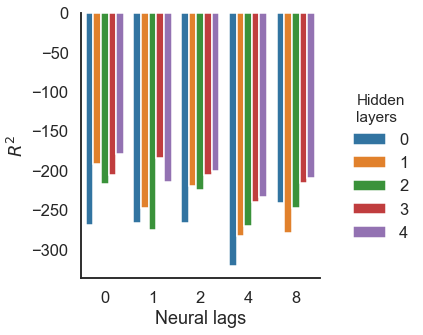

In [5]:
sns.set_style('white'); sns.set_context('talk')

if model_class == 'neural-ae':
    y_axis = 'test_r2' # 'test_loss' | 'test_r2'
    meas_str = 'R2'
    plot_type = 'bar'
elif model_class == 'neural-arhmm':
    y_axis = 'test_fc'
    meas_str = 'FC'
    plot_type = 'boxen'
x_axis = 'n_lags'

splt = sns.catplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, 
    data=best_models_df, ci=None)
if y_axis == 'test_r2':
    splt.ax.set_ylabel('$R^2$')
elif y_axis == 'test_loss':
    splt.ax.set_ylabel('MSE')
elif y_axis == 'test_fc':
    splt.ax.set_ylabel('Fraction correct')
splt.ax.set_xlabel('Neural lags')
if hue is not None:
    splt._legend.set_title('Hidden\nlayers')

# if save_outputs:
#     save_file = os.path.join(results_dir, '%s_decoder_%ss_by_trial' % (lab, meas_str))
# else:
#     save_file = None
    
# if save_file is not None:
#     plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')
    
plt.show()

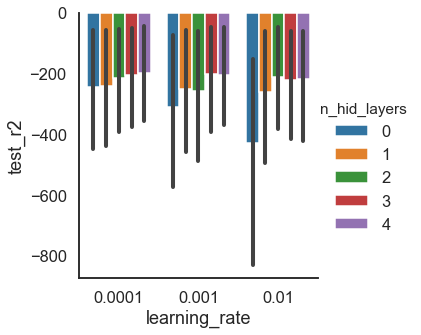

In [6]:
# look at reg vals/learning rate
measure = 'learning_rate'  # 'learning_rate' | 'l2_reg'
get_best = 'l2_reg' if measure == 'learning_rate' else 'learning_rate'
    
# for each version, only keep rows where test_loss is not nan
data_queried = metrics_df[pd.notna(metrics_df.test_loss)]

# group by get_best, find avgs over all other hyperparams
best_meas = data_queried.groupby([get_best]).mean().reset_index()
# find the best value for get_best
best_meas = best_meas[
    best_meas['test_loss']==best_meas['test_loss'].min()][get_best].values[0]
# subsample data with this value
data_queried = data_queried[data_queried[get_best]==best_meas]
splt = sns.catplot(
    x=measure, y='test_r2', hue='n_hid_layers', kind='bar', data=data_queried)

# 2. Make movies

Loading model defined in /home/mattw/results/behavenet/datta/inscopix/15566/2018-11-27/ae/conv/08_latents/test_tube_data/test_pt/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/datta/inscopix/15566/2018-11-27/neural-ae/08_latents/ff/test_tube_data/grid_search/version_6/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000
processing frame 100
processing frame 200
processing frame 300
saving video
video saved to /home/mattw/results/behavenet_figs/datta_08_dim_recon_neural.mp4


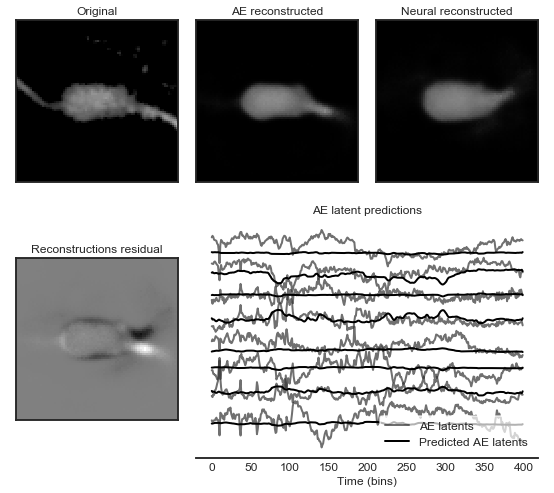

In [37]:
# from analyses.ae.movies import reconstruction
from behavenet.fitting.utils import get_lab_example
from behavenet.data.data_generator import ConcatSessionsGenerator
from behavenet.analyses.ae_utils import make_neural_reconstruction_movie

hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'ae_experiment_name': 'test_pt',
    'ae_model_class': 'ae',
    'ae_model_type': 'conv',
    'ae_version': 'best',
    'decoder_experiment_name': 'grid_search',
    'decoder_model_class': 'neural-ae',
    'decoder_model_type': 'ff',
    'decoder_version': 'best',
    'lib': 'pt'}

# labs = ['musall'] #['steinmetz', 'steinmetz-face', 'musall', 'datta']

# for lab in labs:

get_lab_example(hparams, lab)
# fastest way to get test trials
data_generator = ConcatSessionsGenerator(
    hparams['data_dir'], hparams, 
    signals=['images'], transforms=[None], load_kwargs=[None],
    device='cpu', as_numpy=False, batch_load=True, rng_seed=0)
trial = data_generator.batch_indxs[0]['test'][4]

if save_outputs:
    save_file = os.path.join(
        results_dir, '%s_%02i_dim_recon_neural' % (lab, hparams['n_ae_latents']))
    make_neural_reconstruction_movie(hparams, save_file=save_file, trial=trial)
else:
    pass   

# 3. Plot AE traces and neural reconstructions

FileNotFoundError: [Errno 2] No such file or directory: '/home/mattw/results/behavenet_figs/steinmetz_decoding/08_dim_recon_neural_traces__trial-072.jpg'

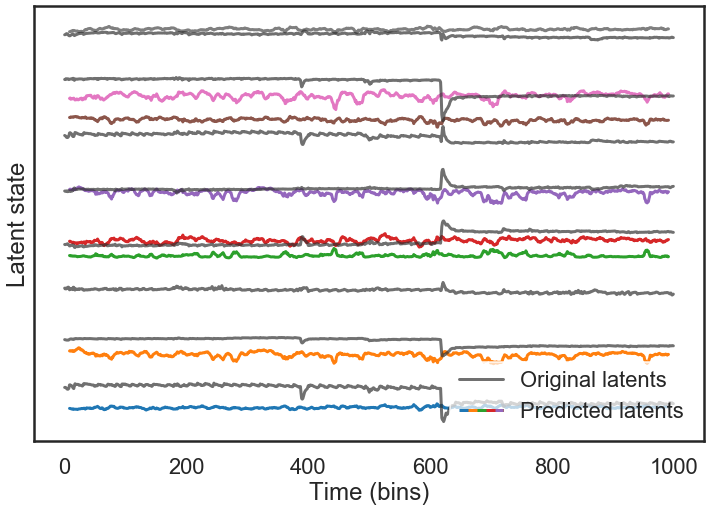

In [14]:
# from analyses.ae.movies import reconstruction
from behavenet.fitting.utils import get_lab_example
from behavenet.data.data_generator import ConcatSessionsGenerator
from behavenet.data.utils import get_data_generator_inputs
from behavenet.analyses.ae_utils import plot_neural_reconstruction_traces

hparams = {
    'data_dir': '/media/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'model_class': 'ae',
    'model_type': 'conv',
    'experiment_name': 'grid_search',
    'ae_experiment_name': 'ae-dim-test',
    'ae_model_class': 'ae',
    'ae_model_type': 'conv',
    'ae_version': 'best',
    'decoder_experiment_name': 'grid_search',
    'decoder_model_class': 'neural-ae',
    'decoder_model_type': 'ff',
    'decoder_version': 'best'}

# labs = ['musall'] #['steinmetz', 'steinmetz-face', 'musall', 'datta']
# for lab in labs:
save_outputs = True
lab = 'steinmetz'
get_lab_example(hparams, lab)
if lab == 'musall':
    trial_splits = {'train_tr': 8, 'val_tr': 1, 'test_tr': 1, 'gap_tr': 0}
elif lab == 'steinmetz':
    trial_splits = {'train_tr': 5, 'val_tr': 1, 'test_tr': 1, 'gap_tr': 1}
    hparams['expt'] = '8-probe'
    hparams['animal'] = 'mouse-02'
    hparams['session'] = 'session-01'
elif lab == 'steinmetz-face':
    trial_splits = {'train_tr': 5, 'val_tr': 1, 'test_tr': 1, 'gap_tr': 1}
    hparams['expt'] = '8-probe-face'
    hparams['animal'] = 'mouse-02'
    hparams['session'] = 'session-01'
hparams['n_ae_latents'] = 8
     
# fastest way to get test trials
hparams['session_dir'], sess_ids = get_output_session_dir(hparams)
hparams['expt_dir'] = get_expt_dir(hparams)
hparams, signals, transforms, paths = get_data_generator_inputs(hparams, sess_ids)
data_generator = ConcatSessionsGenerator(
    hparams['data_dir'], sess_ids, 
    signals_list=signals, transforms_list=transforms, paths_list=paths,
    device='cpu', as_numpy=False, batch_load=True, rng_seed=0,
    trial_splits=trial_splits)
trial = data_generator.datasets[0].batch_indxs['test'][5]

if save_outputs:
    save_file = os.path.join(
    results_dir, '%s_decoding' % lab, 
    '%02i_dim_recon_neural_traces__trial-%03i' % (hparams['n_ae_latents'], trial))
else:
    save_file = None
    
plot_neural_reconstruction_traces(hparams, save_file=save_file, trial=trial)

# 1A. Calculate $R^2$/FC over entire test data

### get best models from before

In [7]:
from behavenet.fitting.eval import get_test_r2

versions = best_models_df.version.unique()

hparams = {
    'data_dir': '/media/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'experiment_name': 'grid_search',
    'model_class': 'neural-ae',
    'n_max_lags': 8}

# labs = ['musall'] #['steinmetz', 'steinmetz-face', 'musall', 'datta']

# for lab in labs:
lab = 'steinmetz-face'
get_lab_example(hparams, lab)

hparams['model_class'] = 'neural-ae'
hparams['subsample_regions'] = 'none'
all_test_r2s = []
for version in versions:
    # get model version/model type
    if len(version) > 13:
        model_version = int(version[13:])
        hparams['model_type'] = 'ff'
    else:
        model_version = int(version[8:])
        hparams['model_type'] = 'linear'
        
    hparams_, r2 = get_test_r2(hparams, model_version)
    all_test_r2s.append(pd.DataFrame({
        'n_hid_layers': hparams_['n_hid_layers'],
        'n_lags': hparams_['n_lags'],
        'r2': r2}, index=[0]))
#     print('version: %i; type: %s' % (model_version, model_type))
all_test_r2s_df = pd.concat(all_test_r2s)

NameError: name 'best_models_df' is not defined

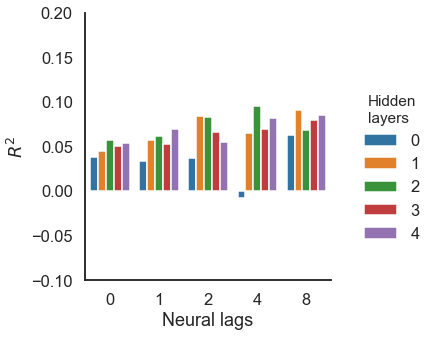

In [14]:
sns.set_style('white'); sns.set_context('talk')
splt = sns.catplot(
    x='n_lags', y='r2', hue='n_hid_layers', kind='bar', data=all_test_r2s_df)
splt.ax.set_ylabel('$R^2$')
splt.ax.set_xlabel('Neural lags')
if hue is not None:
    splt._legend.set_title('Hidden\nlayers')
splt.ax.set_ylim([-0.1, 0.2])
if save_outputs:
    save_file = os.path.join(results_dir, '%s_decoder_R2s_across_trials' % lab)
else:
    save_file = None   
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')
    
plt.show()

# 4. Plot FC across all datasets

In [20]:
from behavenet.fitting.utils import get_subdirs
from behavenet.fitting.utils import get_best_model_version

hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'model_class': 'neural-arhmm',  # 'neural-ae' | 'neural-arhmm'
}

labs = ['musall'] #['steinmetz', 'steinmetz-face', 'musall', 'datta']
model_types = ['ff']

if hparams['model_class'] == 'neural-ae':
    val_meas = 'val_r2'
    test_meas = 'test_r2'
    train_meas = 'tr_r2'
else:
    val_meas = 'val_fc'
    test_meas = 'test_fc'
    train_meas = 'tr_fc'
    
metrics_df = []
for lab in labs:
    hparams['n_arhmm_states'] = 8
    get_lab_example(hparams, lab)
    for model_type in model_types:
        hparams['model_type'] = model_type
        
        # get measures from best decoder
        hparams['experiment_name'] = 'grid_search'
        expt_dir = get_expt_dir(hparams)
        model_version = get_best_model_version(expt_dir)[0]
        metric_file = os.path.join(expt_dir, model_version, 'metrics.csv')
        metrics = pd.read_csv(metric_file)
        for i, row in metrics.iterrows():
            metrics_df.append(pd.DataFrame({
                'epoch': row['epoch'],    'lib': 'pt'
                'loss': row[val_meas],
                'dtype': 'val',
                'model_type': model_type,
                'data': lab,
                'shuffled': False
            }, index=[0]))
            metrics_df.append(pd.DataFrame({
                'epoch': row['epoch'],
                'loss': row[train_meas],
                'dtype': 'train',
                'model_type': model_type,
                'data': lab,
                'shuffled': False
            }, index=[0]))
            if 'test_loss' in row:
                metrics_df.append(pd.DataFrame({
                    'epoch': row['epoch'],
                    'loss': row[test_meas],
                    'dtype': 'test',
                    'model_type': model_type,
                    'data': lab,
                    'shuffled': False
                }, index=[0]))
                
        # get measures from shuffled data
        hparams['experiment_name'] = 'shuffle'
        _, _, expt_dir = get_output_dirs(hparams)
        versions = get_subdirs(expt_dir)
        for version in versions:
            metric_file = os.path.join(expt_dir, version, 'metrics.csv')
            metrics = pd.read_csv(metric_file)
            for i, row in metrics.iterrows():
                metrics_df.append(pd.DataFrame({
                    'epoch': row['epoch'],
                    'loss': row[val_meas],
                    'dtype': 'val',
                    'model_type': model_type,
                    'data': lab,
                    'shuffled': True
                }, index=[0]))
                metrics_df.append(pd.DataFrame({
                    'epoch': row['epoch'],
                    'loss': row[train_meas],
                    'dtype': 'train',
                    'model_type': model_type,
                    'data': lab,
                    'shuffled': True
                }, index=[0]))
                if 'test_loss' in row:
                    metrics_df.append(pd.DataFrame({
                        'epoch': row['epoch'],
                        'loss': row[test_meas],
                        'dtype': 'test',
                        'model_type': model_type,
                        'data': lab,
                        'shuffled': True
                    }, index=[0]))
        
metrics_df = pd.concat(metrics_df)

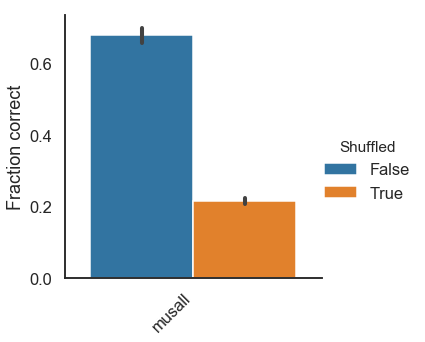

In [21]:
sns.set_style('white'); sns.set_context('talk')

data_queried = metrics_df[metrics_df.dtype=='test']
splt = sns.catplot(
    x='data', y='loss', hue='shuffled', kind='bar', data=data_queried)

plt.ylabel('Fraction correct')
plt.xlabel('')
splt.ax.set_xticklabels(data_queried.data.unique(), rotation=45, ha='right')
splt._legend.set_title('Shuffled')

if save_outputs:
    save_file = os.path.join(results_dir, 'all_decoder_discrete_fcs')
else:
    save_file = None
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')
    
plt.show()

# 5. Make plots for n best/worst trials

Trial 22: -0.2696455314611449


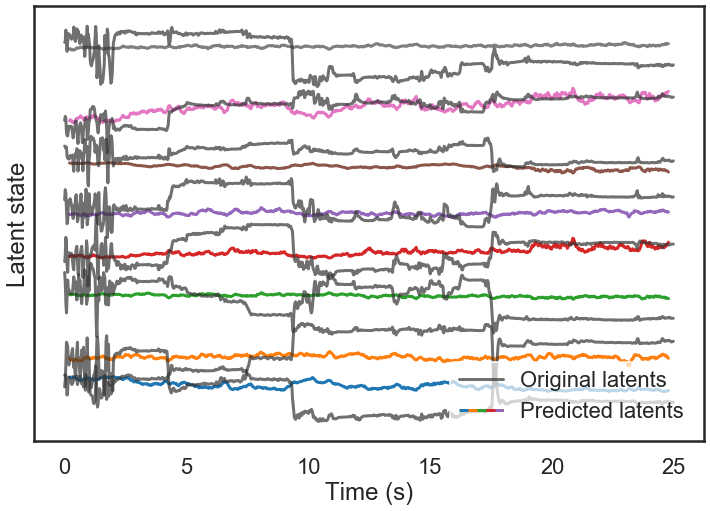

Trial 12: -207.03032291664368


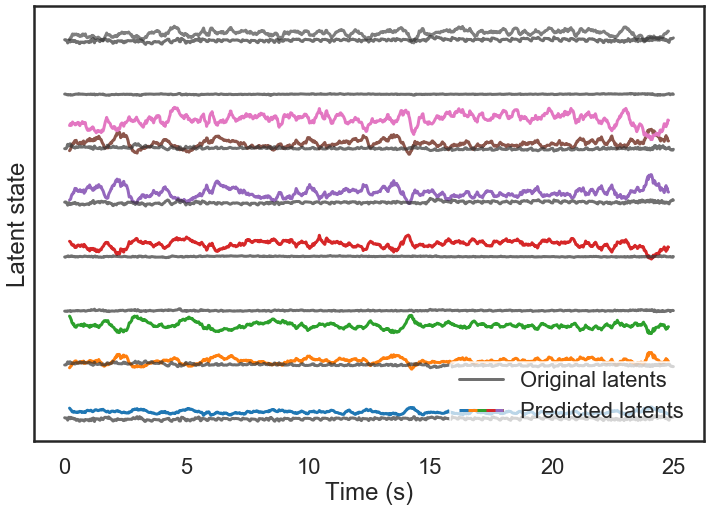

Trial 52: -0.6091712955771109


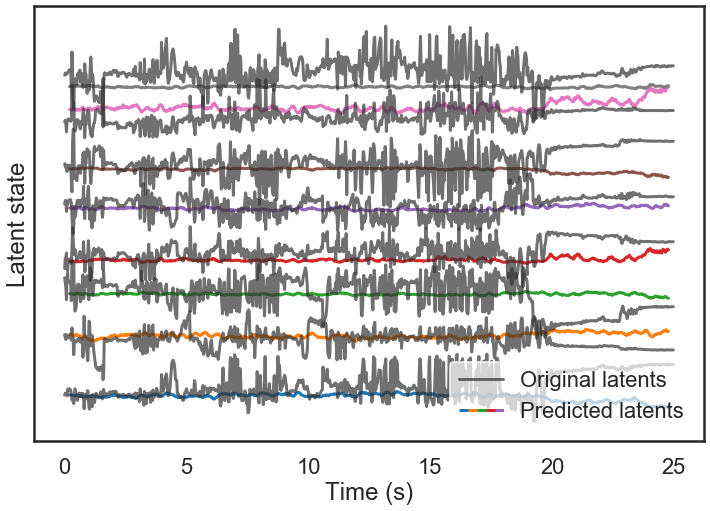

Trial 72: -8.543726946290075


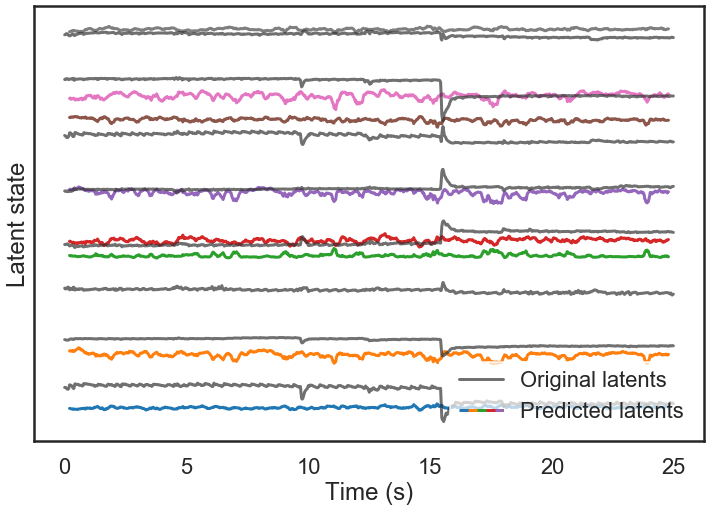

Trial 42: -0.7874507171074455


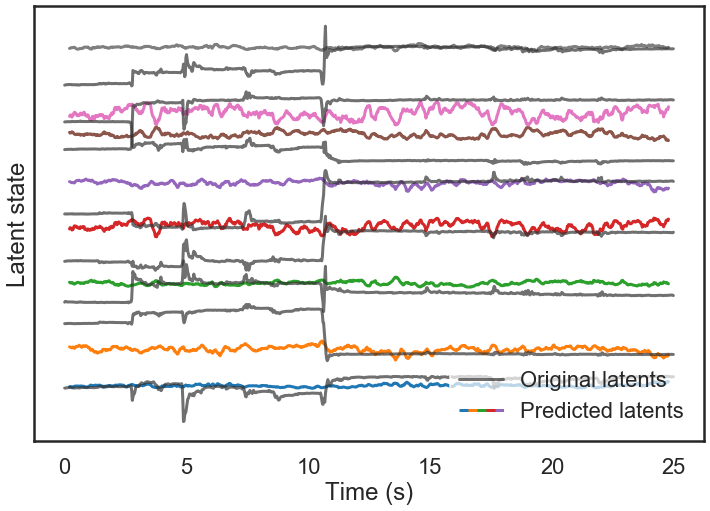

Trial 62: -2.1627603754035984


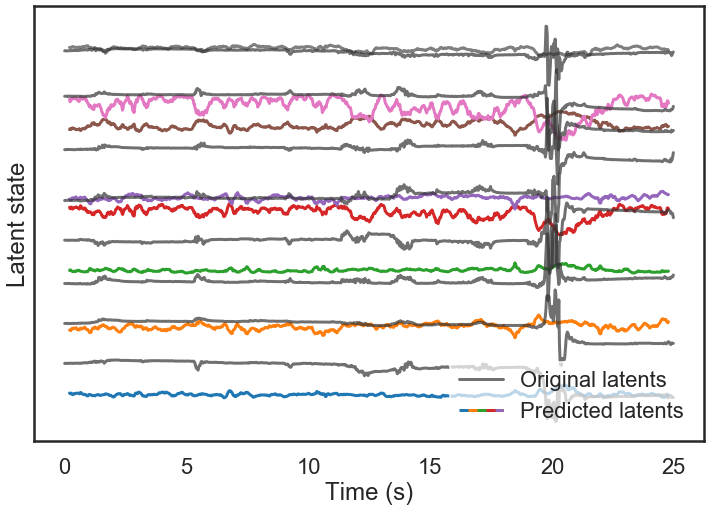

In [5]:
import os
import copy
import pandas as pd
from behavenet.fitting.utils import get_lab_example
from behavenet.fitting.utils import get_best_model_version
from behavenet.fitting.utils import get_output_session_dir
from behavenet.fitting.utils import get_expt_dir
from behavenet.data.data_generator import ConcatSessionsGenerator
from behavenet.analyses.ae_utils import plot_neural_reconstruction_traces

results_dir = '/home/mattw/results/behavenet_figs_final/'
save_outputs = True
n_trials = 3

hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'ae_experiment_name': 'ae-dim-test',
    'ae_model_class': 'ae',
    'ae_model_type': 'conv',
    'ae_version': 'best',
    'decoder_experiment_name': 'grid_search',
    'decoder_model_class': 'neural-ae',
    'decoder_model_type': 'ff',
    'decoder_version': 'best'}

lab = 'steinmetz'
get_lab_example(hparams, lab)
hparams['n_ae_latents'] = 8
if lab == 'steinmetz':
    hparams['expt'] = '8-probe'
    hparams['animal'] = 'mouse-02'
    hparams['session'] = 'session-01'
    xtick_locs = [0, 200, 400, 600, 800, 1000]
    frame_rate = 40
elif lab == 'steinmetz-face':
    hparams['expt'] = '8-probe-face'
    hparams['animal'] = 'mouse-02'
    hparams['session'] = 'session-01'
    xtick_locs = [0, 200, 400, 600, 800, 1000]
    frame_rate = 40
elif lab == 'musall':
    hparams['expt'] = 'vistrained'
    hparams['animal'] = 'mSM36'
    hparams['session'] = '05-Dec-2017'
    xtick_locs = [0, 30, 60, 90, 120, 150, 180]
    frame_rate = 30
    
# load fitting metrics
hparams_ = copy.copy(hparams)
hparams['model_class'] = hparams['decoder_model_class']
hparams['experiment_name'] = hparams['decoder_experiment_name']
hparams['model_type'] = hparams['decoder_model_type']
hparams['session_dir'], sess_ids = get_output_session_dir(hparams)
expt_dir = get_expt_dir(hparams)
best_version = get_best_model_version(expt_dir)[0]
version_dir = os.path.join(expt_dir, best_version)
metrics_file = os.path.join(version_dir, 'metrics.csv')
metrics = pd.read_csv(metrics_file)
metrics = metrics[pd.notna(metrics.test_loss)]

# find r2s of all trials
r2s = metrics['test_r2'].sort_values().reset_index()

for n in range(n_trials):
    # get good trial
    index = r2s.iloc[-1-n]['index']
    trial = int(metrics[metrics.index==index].iloc[0]['trial'])
    r2 = metrics[metrics.index==index].iloc[0]['test_r2']
    print('Trial {}: {}'.format(trial, r2))
    if save_outputs:
        save_file = os.path.join(
            results_dir, '%s_decoding' % lab, 
            '%02i_dim_trial-%03i_r2-%1.2f' % (hparams['n_ae_latents'], trial, r2))
        plot_neural_reconstruction_traces(
            hparams, save_file=save_file, trial=trial, xtick_locs=xtick_locs, 
            frame_rate=frame_rate)
#         make_neural_reconstruction_movie(hparams, save_file=save_file, trial=trial)
    else:
        pass   

    # get bad trials
    index = r2s.iloc[n]['index']
    trial = int(metrics[metrics.index==index].iloc[0]['trial'])
    r2 = metrics[metrics.index==index].iloc[0]['test_r2']
    print('Trial {}: {}'.format(trial, r2))
    if save_outputs:
        save_file = os.path.join(
            results_dir, '%s_decoding' % lab, 
            '%02i_dim_trial-%03i_r2-%1.2f' % (hparams['n_ae_latents'], trial, r2))
        plot_neural_reconstruction_traces(
            hparams, save_file=save_file, trial=trial, xtick_locs=xtick_locs,
            frame_rate=frame_rate)
#         make_neural_reconstruction_movie(hparams, save_file=save_file, trial=trial)
    else:
        pass